# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [13]:
# Your code here
import pandas as pd
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


boston=pd.read_csv('../data/boston_data.csv')

boston.isnull().sum(axis=0)
#print(boston.max())
boston.head()


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

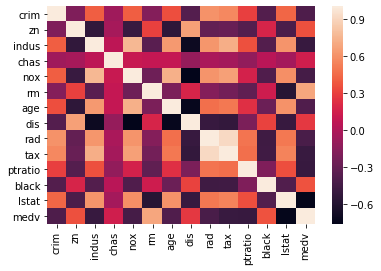

In [23]:
# Your plots here

sns.heatmap(boston.corr())

In [8]:
#boston.corr()



### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

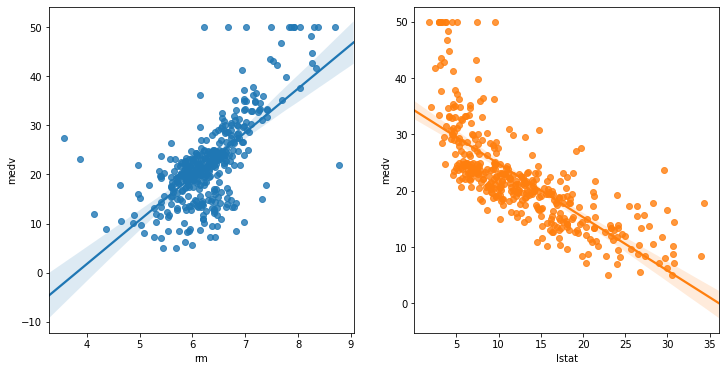

In [6]:
# Your response here

#where there is more correlation is with istat, ptratio, tax, rm, indus
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(x="rm", y="medv", data=boston, ax=axs[0])
sns.regplot(x="lstat", y="medv", data=boston, ax=axs[1])

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

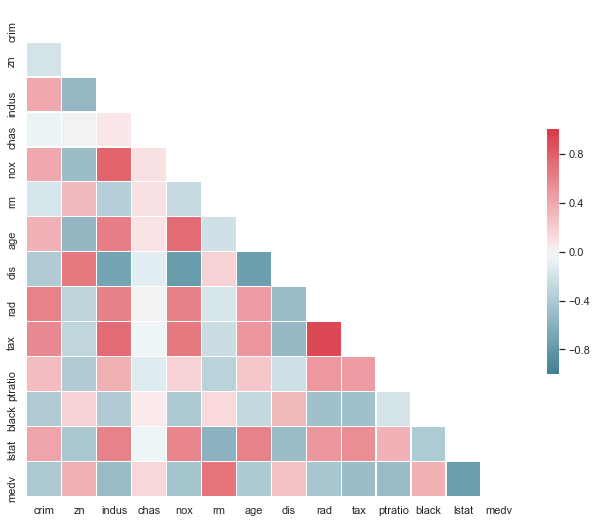

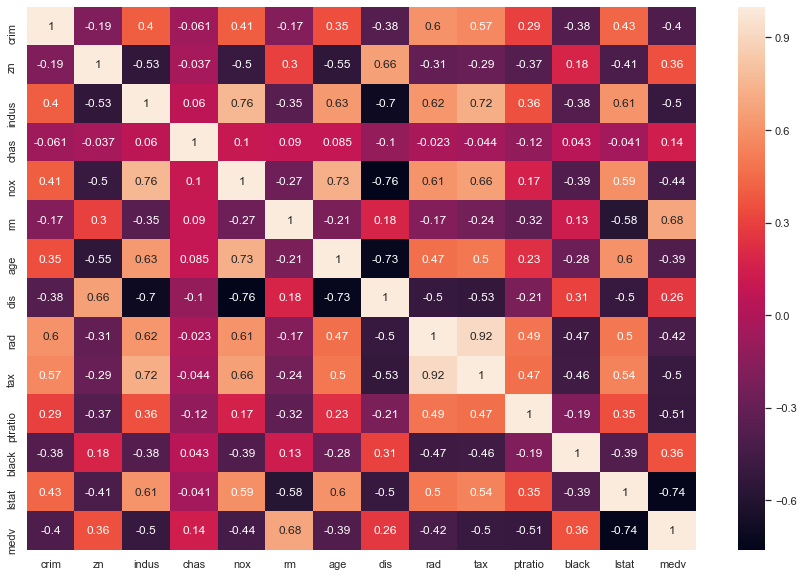

In [7]:
# Your response here
sns.set(style="white")

corr = boston.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin= -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

fig = plt.subplots(figsize=(15,10))
sns.heatmap(boston.corr(), annot=True)

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [26]:
# Your code here
boston .describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [44]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [20]:
# Your code here
from sklearn.model_selection import train_test_split

X = boston.drop(columns=['medv'], axis=1)
y = boston['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 29)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [22]:
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
def get_score(X, y):
    arr = []
    for k in [2, 4, 6, 8, 10]:
        regr = RandomForestRegressor(max_depth=k, random_state=0)
        model = regr.fit(X, y)
        print(k , model.score(X, y))
get_score(X_train, y_train)  
get_score(X_test, y_test)  



from sklearn.ensemble import RandomForestRegressor
tr_scores=[]
te_scores=[]
for d in range(1,10):    
    regr = RandomForestRegressor(max_depth=d)
    regr.fit(X_train, y_train)
    te_scores.append(regr.score(X_test,y_test))
    tr_scores.append(regr.score(X_train,y_train))

/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3

2 0.8094988541815695
4 0.9184167425056621
6 0.95609060238424
8 0.9685628017240043
10 0.9741776447108049
2 0.81330237341938
4 0.9109145268195847
6 0.9351690618234001
8 0.9366686191991418
10 0.9348901552687655


/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3

Now, plot the score for each tree on the training set and on the testing set.

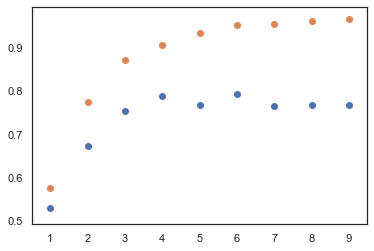

In [23]:
# Produce a plot with the score for the testing and training for the different max depths

#parameters = [2, 4, 6, 8 ,10]
#sns.scatterplot(x = parameters, y = y_train, color = 'red')
#sns.scatterplot(x = parameters, y = y_test, color = 'blue')



# Produce a plot with the score for the testing and training for the different max depths
plt.scatter(range(1,10), te_scores)
plt.scatter(range(1,10), tr_scores)


What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here
higher depth get higher scores but more overfitting

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [ ]:
# Your response here
# high variance and low bias, since it is overfitting, with a high score for the training data.

for d in range(1,12):    
    regr = RandomForestRegressor(max_depth=d)
    regr.fit(X_train, y_train)
    print(regr.score(X_train,y_train), regr.score(X_train,y_train) - regr.score(X_test,y_test))
    
# around 3, since it is more optmal considering bias and variance, higher score considering
# the different scores between train and test

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [28]:
# Your response here

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler



In [26]:
for d in range(1,12):    
    regr = RandomForestRegressor(max_depth=d)
    regr.fit(X_train, y_train)
    print(regr.score(X_train,y_train), regr.score(X_train,y_train) - regr.score(X_test,y_test))
    
# around 3, since it is more optmal considering bias and variance, higher score considering
# the different scores between train and test

/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Estelle/anaconda3/lib/python3

0.5673638735795113 0.07598639432536336
0.8014048932851937 0.14980131453901058
0.8616082995040151 0.12761191586863885
0.9053236864456375 0.13886079091796988
0.9373060128441223 0.1336988020720179
0.9466986577292492 0.16430821994839917
0.960865470745154 0.16691058203462195
0.966735918705455 0.18287925539074346
0.9649285244695367 0.19060937585232263
0.9717271720114437 0.16428071886888584
0.9607592398488966 0.21105738846159838


### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here